Reference: https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb

In [ ]:
import torch
if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device= torch.device("cpu")
  print(device)

cuda Tesla P100-PCIE-16GB


In [ ]:
%%shell
pip install cython
# Install pycocotools to compute IOU
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-fp0bvkjc
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-fp0bvkjc
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263918 sha256=85fe4411cc08afd2a976866285750a37899045287f9ec3e86949fc1793fc25ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-7wtqfwvr/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
# connect to Google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


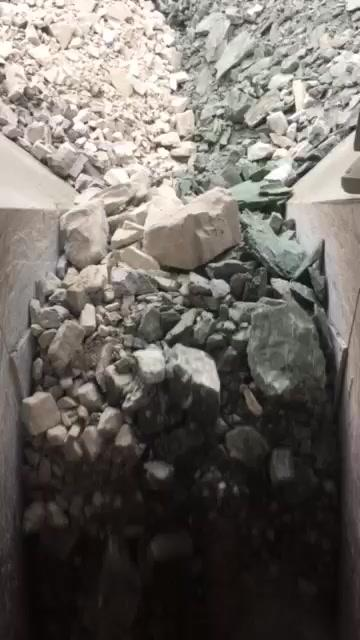

In [ ]:
#take a look at one picture
from PIL import Image
Image.open("/content/gdrive/MyDrive/Object Detection Image Folder/pic/0001.jpg")

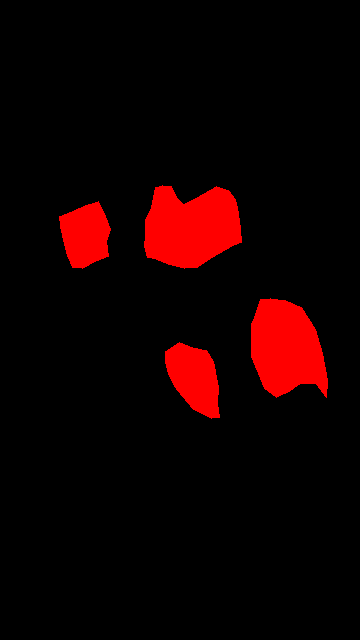

In [ ]:
# take a look at one mask
mask = Image.open('/content/gdrive/MyDrive/Object Detection Image Folder/mask/0001.png')
# Each mask instance has a different color,0~N, where N is the number of instances. 
# In order to visualzie, we add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class StoneDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    # load all image files, sorting them to ensure that they are aligned
    self.imgs=list(sorted(os.listdir(os.path.join(root,"pic"))))
    self.masks=list(sorted(os.listdir(os.path.join(root,"mask"))))

  def __getitem__(self, idx):
    # load images ad masks
    img_path=os.path.join(self.root,"pic",self.imgs[idx])
    mask_path=os.path.join(self.root,"mask",self.masks[idx])
    img=Image.open(img_path).convert("RGB")
    #We do not converted the mask to RGB bbecause each color corresponds to a different instance
    # with 0 being background
    mask = Image.open(mask_path)
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask) 
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set of binary masks
    masks = mask == obj_ids[:, None, None]

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target

  def __len__(self):
      return len(self.imgs)

In [ ]:
dataset = StoneDataset('/content/gdrive/MyDrive/Object Detection Image Folder/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=360x640 at 0x7FEAC5C7A6D0>,
 {'area': tensor([62444.]),
  'boxes': tensor([[ 59., 185., 327., 418.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier 
num_classes = 2  # 1 class (person) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(num_classes):
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,                                                   hidden_layer,                                                      num_classes)

  return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 22601, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 22601 (delta 22), reused 22 (delta 3), pack-reused 22538
Receiving objects: 100% (22601/22601), 27.39 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (16715/16715), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
  transforms = []
  # converts the image, a PIL image, into a PyTorch Tensor
  transforms.append(T.ToTensor())
  if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = StoneDataset('/content/gdrive/MyDrive/Object Detection Image Folder/', get_transform(train=True))
dataset_test = StoneDataset('/content/gdrive/MyDrive/Object Detection Image Folder/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=2, 
    shuffle=True, 
    num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size=1, 
    shuffle=False, 
    num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)                                       

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
for epoch in range(10):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/20]  eta: 0:01:04  lr: 0.000268  loss: 3.3367 (3.3367)  loss_classifier: 0.7079 (0.7079)  loss_box_reg: 0.1177 (0.1177)  loss_mask: 2.4933 (2.4933)  loss_objectness: 0.0119 (0.0119)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 3.2353  data: 2.5175  max mem: 2483
Epoch: [0]  [10/20]  eta: 0:00:07  lr: 0.002897  loss: 1.3361 (1.7297)  loss_classifier: 0.1779 (0.2886)  loss_box_reg: 0.0578 (0.0657)  loss_mask: 1.0733 (1.2952)  loss_objectness: 0.0762 (0.0733)  loss_rpn_box_reg: 0.0060 (0.0068)  time: 0.7238  data: 0.3247  max mem: 2759
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.005000  loss: 0.8906 (1.2921)  loss_classifier: 0.1090 (0.2024)  loss_box_reg: 0.0579 (0.0652)  loss_mask: 0.6534 (0.9624)  loss_objectness: 0.0416 (0.0560)  loss_rpn_box_reg: 0.0045 (0.0061)  time: 0.6082  data: 0.2312  max mem: 2759
Epoch: [0] Total time: 0:00:12 (0.6111 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:15  model_time: 0.0957 (0.0957)  evaluator_time: 0.0014 (0.0014)  

#Test

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[6.1202e+01, 9.6344e+01, 3.6000e+02, 2.6960e+02],
          [9.7210e+01, 2.1766e-01, 2.7205e+02, 3.1256e+02],
          [1.5838e+02, 2.8472e-01, 3.3366e+02, 3.1244e+02],
          [3.4931e+01, 0.0000e+00, 2.1023e+02, 3.1373e+02],
          [2.1841e+01, 7.9312e+01, 2.9134e+02, 3.5570e+02],
          [2.2304e+01, 0.0000e+00, 2.9336e+02, 2.0002e+02],
          [3.5317e+01, 8.9269e+01, 2.1060e+02, 4.6498e+02],
          [6.3115e+01, 1.5774e+02, 3.6000e+02, 3.3107e+02],
          [1.2795e+02, 5.9964e+01, 3.0264e+02, 4.3292e+02],
          [9.1826e+01, 3.4778e+01, 3.6000e+02, 2.0800e+02],
          [9.8634e+01, 1.5101e+02, 2.7237e+02, 5.2537e+02],
          [1.7586e+02, 1.0855e+02, 3.6000e+02, 3.8689e+02],
          [9.6539e+01, 2.1816e+02, 3.6000e+02, 3.9411e+02],
          [2.7062e+00, 2.4890e+02, 3.1437e+02, 4.2376e+02],
          [1.2924e+02, 2.4270e+02, 3.0367e+02, 6.1950e+02],
          [6.7772e+01, 2.7389e+02, 2.4039e+02, 6.3817e+02],
          [9.7517e+01, 2.7918e+

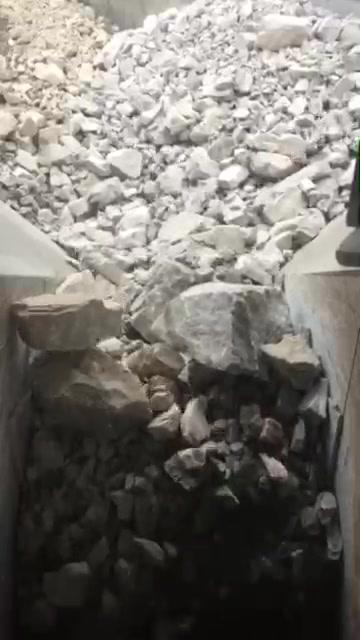

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

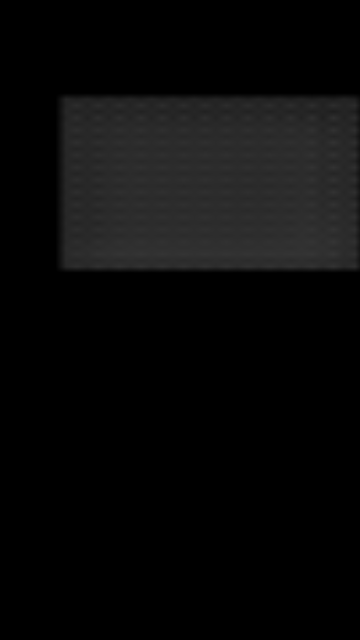

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())